# 학습 알고리즘 구현
- 미니배치
- 신경망 학습
- 학습 데이터 평가
----

## **전체적인 학습 과정**
1. 학습에 맞게 신경망을 구성하며, 가중치는 랜덤으로, 편향은 0으로 설정한다.
2. 학습 데이터를 랜덤하게 선별하여 미니배치를 준비한다 -> **미니배치**
3. 미니배치 데이터를 신경망에 넣어 계산한다. -> **sigmoid, softmax**
4. 출력값의 손실 함수를 구한다 -> **평균 제곱 오차, 교차 엔트로피 오차**
5. 손실 함수를 바탕으로 수치 미분 or 오차역전파를 수행한다 -> **중앙 차분, 편미분**
6. 기울기를 구하고 가중치를 설정한다 -> **경사하강법, 학습률, 기울기**
7. 2번~6번의 결과를 반복이 끝날 때 까지 수행한다.




#### 필요 라이브러리, 데이터셋 import

In [64]:
import numpy as np
import matplotlib.pylab as plt
import sys, os
sys.path.append(os.pardir)

from dataset.mnist import load_mnist

## --사용 함수--
----

### 활성화 함수
- 시그모이드
- 소프트맥스 (크기에 맞게 변경)

### 손실 함수
- 교차 엔트로피 오차

### 기울기
- 편미분, 수치 미분 --> 기울기

In [65]:
def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y

In [66]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

In [67]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        x[idx] = tmp_val - h
        fxh2 = f(x)
    
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
    
    return grad

In [68]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

## 학습에 사용될 클래스

In [69]:
class TwoLayerNet:

    # 가중치 초기화
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        
    # 가중치와 편향으로 계산 신경망 계산
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
        
    # 교차 엔트로피 오차 손실 함수를 구한다
    def loss(self, x, t):
        # x : 입력 데이터, t : 정답 레이블
        y = self.predict(x)
        return cross_entropy_error(y, t)

    
    # 정확도 구하기
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
        
    # 수치 미분으로 기울기 구하기
    def numerical_gradient(self, x, t):
        # x : 입력 데이터, t : 정답 레이블
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads

    
    # 오차역전파법으로 기울기 구하기 -> 5장 학습 후 다시 보기
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

## 미니배치 학습

In [70]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [71]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [72]:
iters_num = 10000  
train_size = x_train.shape[0]
print(train_size)
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

60000


In [73]:
iter_per_epoch = max(train_size // batch_size, 1)
print(iter_per_epoch)

600


In [74]:
for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산 -> 
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key] 
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.09863333333333334, 0.0958
train acc, test acc | 0.7907166666666666, 0.7958
train acc, test acc | 0.8755666666666667, 0.8801
train acc, test acc | 0.8982833333333333, 0.8998
train acc, test acc | 0.9070666666666667, 0.9099
train acc, test acc | 0.9141666666666667, 0.9153
train acc, test acc | 0.9194166666666667, 0.9199
train acc, test acc | 0.9236333333333333, 0.923
train acc, test acc | 0.9268333333333333, 0.9273
train acc, test acc | 0.9303166666666667, 0.93
train acc, test acc | 0.9322333333333334, 0.9324
train acc, test acc | 0.93715, 0.9352
train acc, test acc | 0.9395333333333333, 0.9367
train acc, test acc | 0.94095, 0.9381
train acc, test acc | 0.94315, 0.9412
train acc, test acc | 0.94425, 0.943
train acc, test acc | 0.9466166666666667, 0.9432


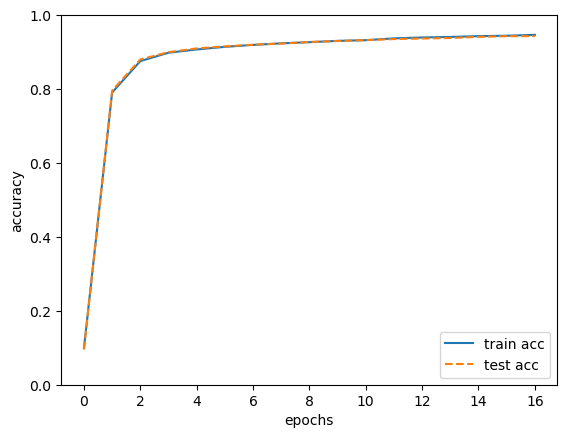

In [75]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
